<a href="https://colab.research.google.com/github/kgb0255/GQPMC_v4_JAMES/blob/main/fractional_error_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My\ Drive/speculator_fork

/content/drive/.shortcut-targets-by-id/1mXOA5v3haTos5p9R5pMbAORSsvd9WFLa/speculator_fork


In [ ]:
import os 
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import h5py

from speculator import SpectrumPCA
from speculator import Speculator

In [ ]:
# read DESI wavelength
wave = np.load('wave_fsps.npy')

In [24]:
def frac_plot(ax,n_pca,dust):
  if dust == 'simpledust':
    n_param = 8
  else:
    n_param = 10
  n_wave  = len(wave)
  batches = '0_99'
  n_pcas  = n_pca
  theta_test = np.load(f'DESI_{dust}.theta_test.npy')

  print('training PCA bases') 
  PCABasis = SpectrumPCA(
          n_parameters=n_param,       # number of parameters
          n_wavelengths=n_wave,       # number of wavelength values
          n_pcas=n_pcas,              # number of pca coefficients to include in the basis 
          spectrum_filenames=[f'DESI_{dust}.logspectrum_fsps_test.npy'],  # list of filenames containing the (un-normalized) log spectra for training the PCA
          parameter_filenames=[f'DESI_{dust}.theta_test.npy'], # list of filenames containing the corresponding parameter values
          parameter_selection=None) # pass an optional function that takes in parameter vector(s) and returns True/False for any extra parameter cuts we want to impose on the training sample (eg we may want to restrict the parameter ranges)
  PCABasis._load_from_file(f'DESI_{dust}.%s.seed0.pca%i.hdf5' % (batches, n_pcas))
  speculator = Speculator(restore=True, restore_filename=f'_james_DESI_{dust}_model.%s.pca%i.log' % (batches, n_pcas))

  spectra = np.load(f'DESI_{dust}.logspectrum_fsps_test.npy')
  PCABasis.compute_spectrum_parameters_shift_and_scale()
  normalized_spectra = (spectra - PCABasis.spectrum_shift)/PCABasis.spectrum_scale
  
  fitted_norm_spec = []
  fit = PCABasis.PCA.fit(normalized_spectra)
  true_pca = PCABasis.PCA.transform(normalized_spectra)

  #predicted PCA
  spec_pca = speculator.call(theta_test.astype(np.float32))
  print('spec_pca done')
  #true PCA

  print(spec_pca.shape)
  print(true_pca.shape)

  ax.set_title(f'n_pca: {n_pca}\n{dust}')
  jump = 100
  for i in range(n_pcas):
    ax.plot(np.arange(10000//jump),(spec_pca[::jump,i]-true_pca[::jump,i])/(true_pca[::jump,i]), c = 'steelblue', alpha = 0.1)
    ax.set_ylim(1,-1)
  return spec_pca,true_pca

training PCA bases
spec_pca done
(10000, 20)
(10000, 20)
training PCA bases
spec_pca done
(10000, 30)
(10000, 30)
training PCA bases
spec_pca done
(10000, 40)
(10000, 40)


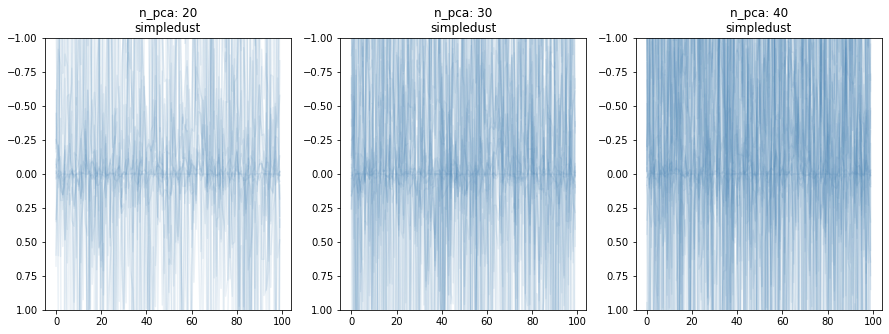

In [25]:
fig, axs = plt.subplots(1,3,figsize=(15,5))
simple_spec_20, true_simple_20 = frac_plot(axs[0],20,'simpledust')
simple_spec_30, true_simple_30 = frac_plot(axs[1],30,'simpledust')
simple_spec_40, true_simple_40 = frac_plot(axs[2],40,'simpledust')

training PCA bases
spec_pca done
(10000, 30)
(10000, 30)
training PCA bases
spec_pca done
(10000, 40)
(10000, 40)
training PCA bases
spec_pca done
(10000, 50)
(10000, 50)


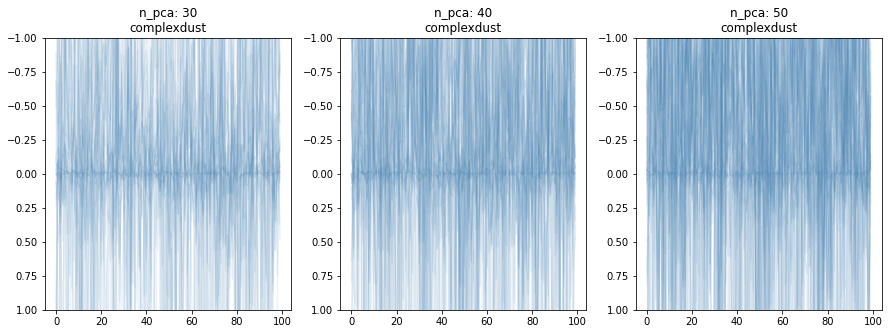

In [26]:
fig, axs = plt.subplots(1,3,figsize=(15,5))
complex_spec_30, true_complex_30 = frac_plot(axs[0],30,'complexdust')
complex_spec_40, true_complex_40 = frac_plot(axs[1],40,'complexdust')
complex_spec_50, true_complex_50 = frac_plot(axs[2],50,'complexdust')